download historical data

[*********************100%***********************]  10 of 10 completed
Model is not converging.  Current: 86.69122924026945 is not greater than 113.82254652217429. Delta is -27.131317281904842
Model is not converging.  Current: 93.56236904099565 is not greater than 95.00007472681882. Delta is -1.4377056858231754
Model is not converging.  Current: 84.6156472377921 is not greater than 116.99706219545178. Delta is -32.38141495765967
Model is not converging.  Current: 90.1562570460877 is not greater than 110.1765745272132. Delta is -20.020317481125502
Model is not converging.  Current: 90.1003156419173 is not greater than 118.7954848092528. Delta is -28.695169167335493
Model is not converging.  Current: 90.7218847285139 is not greater than 102.47779698363338. Delta is -11.755912255119483
Model is not converging.  Current: 93.50912984828938 is not greater than 108.37361530281105. Delta is -14.86448545452167
Model is not converging.  Current: 93.48498186905321 is not greater than 99.99759680

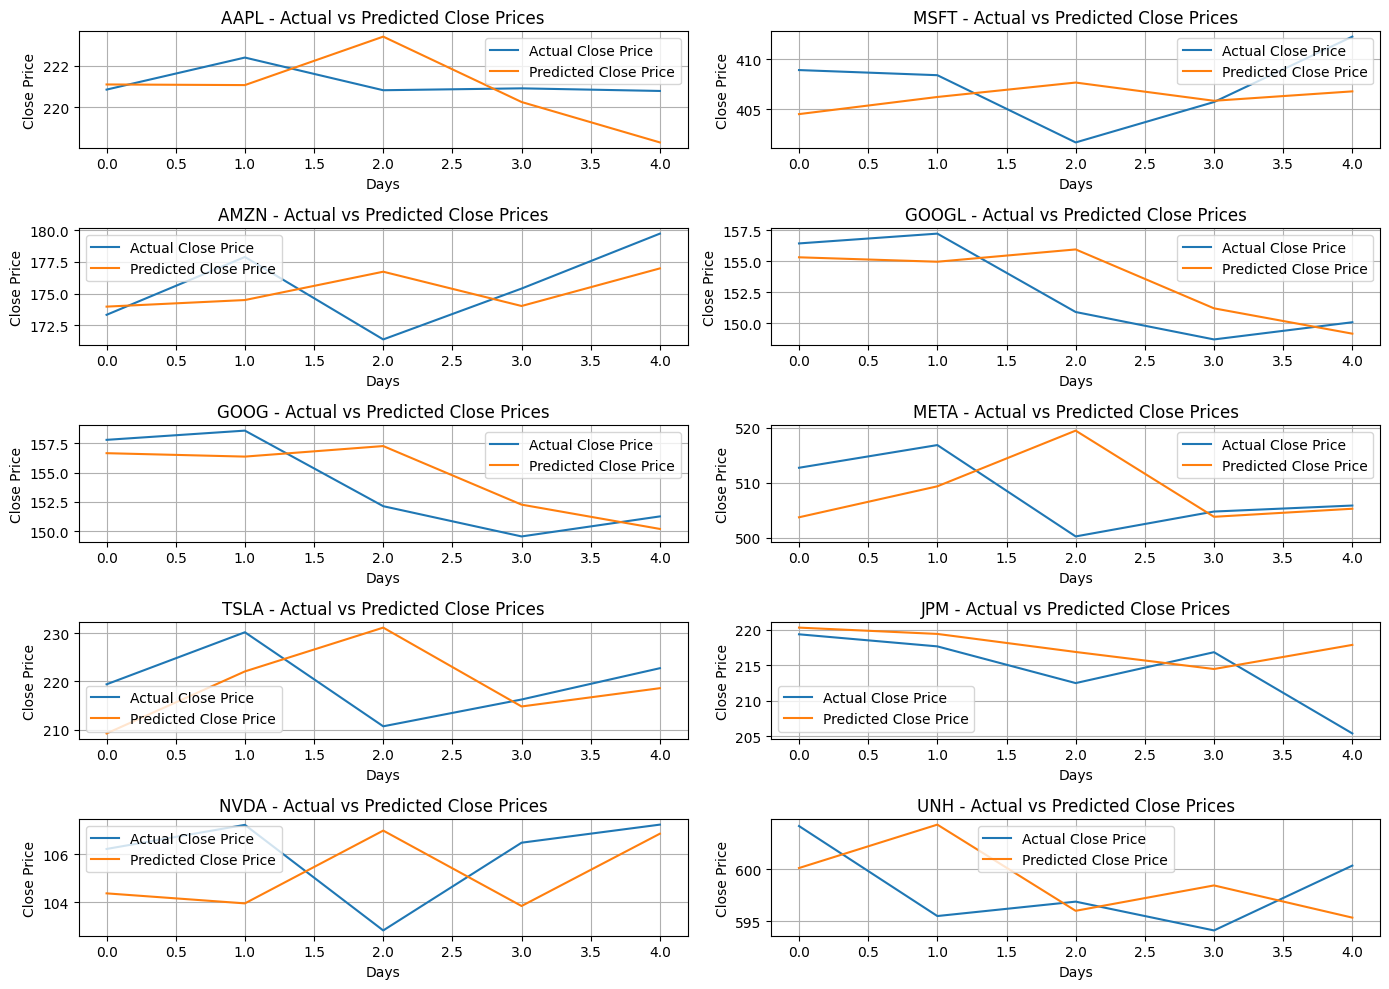

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from hmmlearn.hmm import GaussianHMM

import warnings
warnings.filterwarnings('ignore')

# List of top 10 tickers of S&P 500 stocks
top_10_snp_500_tickers = [
    "AAPL",  # Apple Inc.
    "MSFT",  # Microsoft Corporation
    "AMZN",  # Amazon.com Inc.
    "GOOGL",  # Alphabet Inc. (Class A)
    "GOOG",  # Alphabet Inc. (Class C)
    "META",  # Meta Platforms Inc.
    "TSLA",  # Tesla Inc.
    "JPM",  # JPMorgan Chase & Co.
    "NVDA",  # NVIDIA Corporation
    "UNH"   # UnitedHealth Group Incorporated
]
tickers = top_10_snp_500_tickers

# Download data for the last 1 month to ensure we capture at least 15 market days
data = yf.download(tickers=tickers, period='1mo').stack()

# Clean up the columns and index
data = data.reset_index()  # Reset index to work with columns
data.columns = data.columns.str.replace(' ', '')
data.set_index(['Date', 'Ticker'], inplace=True)  # Set the index back

# Filter to get the last 15 market days
data = data.groupby(level='Ticker').tail(15)

# Prepare to store the predictions and actual prices for plotting
predicted_close_prices = {}
actual_close_prices = {}

# Loop through each ticker to train HMM and predict prices
for ticker in tickers:
    stock_data = data.xs(ticker, level='Ticker')
    
    # Calculate fractional changes
    stock_data['fracChange'] = (stock_data['Close'] - stock_data['Open']) / stock_data['Open']
    stock_data['fracHigh'] = (stock_data['High'] - stock_data['Open']) / stock_data['Open']
    stock_data['fracLow'] = (stock_data['Open'] - stock_data['Low']) / stock_data['Open']
    
    # Discretize the data
    nfc, nfh, nfl = 50, 10, 10
    fracChange_bins = np.linspace(stock_data['fracChange'].min(), stock_data['fracChange'].max(), nfc)
    fracHigh_bins = np.linspace(stock_data['fracHigh'].min(), stock_data['fracHigh'].max(), nfh)
    fracLow_bins = np.linspace(stock_data['fracLow'].min(), stock_data['fracLow'].max(), nfl)
    
    stock_data['disc_fracChange'] = np.digitize(stock_data['fracChange'], fracChange_bins)
    stock_data['disc_fracHigh'] = np.digitize(stock_data['fracHigh'], fracHigh_bins)
    stock_data['disc_fracLow'] = np.digitize(stock_data['fracLow'], fracLow_bins)
    
    # Combine the discretized features into a single state space
    stock_data['state'] = (stock_data['disc_fracLow'] - 1) * (nfc * nfh) + (stock_data['disc_fracHigh'] - 1) * nfc + stock_data['disc_fracChange']
    
    # Prepare training data
    X = stock_data[['fracChange', 'fracHigh', 'fracLow']].values
    
    # Train the HMM
    model = GaussianHMM(n_components=4, covariance_type="diag", n_iter=1000)
    model.fit(X)
    
    # Predict the stock prices for the last 5 days
    n_days = 5
    bin_size = 10
    predicted_close = []
    
    for i in range(len(stock_data) - n_days, len(stock_data)):
        recent_data = X[i-bin_size:i]
        hidden_states = model.predict(recent_data)
        
        # Predict the next day's state
        next_state = model.transmat_[hidden_states[-1]].argmax()
        mean_fracChange = model.means_[next_state][0]
        
        next_open = stock_data['Open'].iloc[i]
        predicted_close.append(next_open * (1 + mean_fracChange))
    
    # Store the actual and predicted prices
    predicted_close_prices[ticker] = predicted_close
    actual_close_prices[ticker] = stock_data['Close'].iloc[-n_days:].values

# Plot the actual vs predicted close prices for each stock
plt.figure(figsize=(14, 10))

for i, ticker in enumerate(tickers):
    plt.subplot(5, 2, i+1)
    plt.plot(actual_close_prices[ticker], label='Actual Close Price')
    plt.plot(predicted_close_prices[ticker], label='Predicted Close Price')
    plt.title(f'{ticker} - Actual vs Predicted Close Prices')
    plt.xlabel('Days')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()
